In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import nltk
import keras

from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
from string import punctuation, digits
from nltk.corpus import stopwords

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import Conv1D, MaxPooling1D, Concatenate, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import GlobalAveragePooling1D
from keras.preprocessing import sequence

Using TensorFlow backend.


## 1. 数据预处理

In [2]:
# 读取全集
newsgroups_all = fetch_20newsgroups(subset='all').data
print(type(newsgroups_all))
print(len(newsgroups_all))

<class 'list'>
18846


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 20000 # 保留最常见的20000个单词
MAX_SEQUENCE_LENGTH = 1000 # 每篇文档限定1000词以内

tokenizer = Tokenizer(num_words=MAX_NB_WORDS) # 分词器
tokenizer.fit_on_texts(newsgroups_all)

# 文本转化为数字序列
sequences = tokenizer.texts_to_sequences(newsgroups_all)

# 词汇表：单词-数字映射
word_index = tokenizer.word_index # {'the': 1, 'to': 2, 'of': 3, 'a': 4, 'and': 5, ……}

In [4]:
print(sequences[:2])

[[14, 19415, 455, 559, 15, 29, 2552, 1240, 5609, 33, 322, 767, 2175, 2121, 871, 1343, 32, 251, 88, 77, 84, 12087, 455, 559, 15, 7, 122, 228, 63, 3, 2552, 1240, 20, 517, 3490, 50, 1, 1393, 3, 61, 437, 3, 1507, 50, 1, 1302, 2552, 3027, 3, 1, 2701, 309, 7, 122, 243, 16334, 175, 5, 4, 243, 19416, 268, 7, 122, 194, 2, 296, 37, 337, 2, 369, 4389, 22, 4, 243, 3, 7286, 12, 1, 2552, 349, 30, 20, 1502, 137, 2701, 1382, 90, 7, 397, 5987, 74, 2025, 13, 130, 56, 8, 140, 215, 90, 93, 1457, 770, 1963, 56, 8, 97, 4, 308, 9186, 1857, 2, 1306, 6, 1, 2327, 6760, 115, 348, 5987, 21, 4, 308, 3, 1857, 6, 1, 365, 658, 3, 467, 185, 1, 2552, 20, 194, 2, 1985, 1, 66, 3, 3215, 608, 7, 26, 132, 8755, 19, 2, 131, 1, 3280, 2000, 1, 1151, 1457, 770, 283, 2552, 1222], [14, 2333, 1832, 2803, 15, 1285, 129, 29, 67, 315, 847, 2812, 556, 344, 660, 3380, 4868, 12, 2812, 556, 344, 88, 77, 84, 2333, 1832, 2803, 15, 33, 560, 181, 591, 72, 3, 4839, 4815, 603, 219, 426, 5849, 3570, 2812, 32, 383, 38, 2459, 8, 6, 1, 1182, 12, 4

In [5]:
len(word_index)

179209

In [6]:
# 按照最大文本长度截断文本或补0
features = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [7]:
print(features[:2])

[[   0    0    0 ...,  283 2552 1222]
 [   0    0    0 ..., 8276  129   95]]


In [8]:
labels = fetch_20newsgroups(subset='all').target

In [9]:
labels

array([10,  3, 17, ...,  3,  1,  7])

In [10]:
# 标签 独热编码
from keras.utils import to_categorical
labels = to_categorical(labels)
labels[:2]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [11]:
print(features.shape)
print(labels.shape)

(18846, 1000)
(18846, 20)


In [12]:
# 拆分训练集，验证集和测试集
from sklearn.model_selection import train_test_split

x_tv, x_test, y_tv, y_test = train_test_split(features, labels, test_size=0.4, shuffle=False) # 测试集占据0.4
x_train, x_val, y_train, y_val = train_test_split(x_tv, y_tv, test_size=0.2, shuffle=False) # 验证集占据0.6数据集中的0.2 = 0.12

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(9045, 1000) (2262, 1000) (7539, 1000)
(9045, 20) (2262, 20) (7539, 20)


In [13]:
# 查看并统计训练集，验证集和测试集中个类别分布
train_c = np.zeros(20, dtype=float)
val_c = np.zeros(20, dtype=float)
test_c = np.zeros(20, dtype=float)
for x in y_train:
    train_c += x

for x in y_val:
    val_c += x

for x in y_test:
    test_c += x

print(train_c)
print(val_c)
print(test_c)

[ 375.  471.  457.  470.  459.  508.  466.  454.  509.  473.  479.  457.
  508.  462.  473.  484.  433.  439.  363.  305.]
[ 103.  111.  130.  114.  114.  108.  124.  116.  125.  121.  121.  128.
  110.  118.  112.  110.  114.  113.   88.   82.]
[ 321.  391.  398.  398.  390.  372.  385.  420.  362.  400.  399.  406.
  366.  410.  402.  403.  363.  388.  324.  241.]


## 2. 从GloVe文件中读取预训练的100维词向量

In [14]:
# 从GloVe文件中解析出每个词和它所对应的词向量，并用字典的方式存储
# 使用的词向量：100维
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as txtfile:
    lines = txtfile.readlines()
    for line in lines:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(len(embeddings_index))

400000


In [15]:
print(embeddings_index['the'])

[-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
 -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
  0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
 -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
  0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
 -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
  0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
  0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
 -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
 -0.80480999 -3.0243001   0.01254    -0.36941999  2.21670008  0.72201002
 -0.24978     0.92136002  0.034514    0.46744999  1.10790002 -0.19358
 -0.074575    0.23353    -0.052062   -0.22044     0.057162   -0.15806
 -0.30798    -0.41624999  0.37972     0.15006    -0.53211999 -0.20550001
 -1.25259995  0.071624    0.70564997  0.49744001 -0.42063001  0.26148
 -

In [16]:
# 构建词向量矩阵, 没有的单词的词向量均为0
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, idx in word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        embedding_matrix[idx] = embed_vector

In [17]:
embedding_matrix[:5, :5]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ],
       [-0.18970001,  0.050024  ,  0.19084001, -0.049184  , -0.089737  ],
       [-0.1529    , -0.24279   ,  0.89837003,  0.16996001,  0.53516001],
       [-0.27085999,  0.044006  , -0.02026   , -0.17395   ,  0.6444    ]])

# Embedding_layer 可以被训练

In [18]:
# 词向量加载到embedding层中，trainable=False 使得这个编码层不可再训练
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

## 3. CNN + 可训练Embedding layer

In [19]:
# 模型记录在logs文件中，使用tensorboard查看
tb = [keras.callbacks.TensorBoard(log_dir='./logs')]

# 输入
main_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float64')
# 词嵌入, 使用已训练完成的词向量
embedding_layer = Embedding(len(word_index) + 1, embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embed = embedding_layer(main_input)
# 使用3层卷积池化
x = Conv1D(128, 5, activation='relu')(embed)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x) # 可以使用 GlobalMaxPooling1D()(x) 防止计算错误
x = Flatten()(x)
x = Dropout(0.5)(x) # 丢弃50%
x = Dense(128, activation='relu')(x)
preds = Dense(20, activation='softmax')(x)
model = Model(inputs=main_input, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary()) # 查看模型概况

# history_cnn记录训练结果
history_cnn = model.fit(x_train, y_train, batch_size=128, epochs=25, callbacks=tb, validation_data=(x_val, y_val))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         17921000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
__________

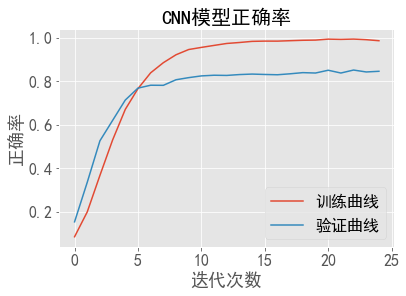

In [20]:
# 绘制模型的训练和验证曲线
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])

plt.legend(['训练曲线', '验证曲线'], loc='lower right', fontsize=16)

plt.title('CNN模型正确率', fontsize=20)
plt.xlabel('迭代次数', fontsize=18)
plt.ylabel('正确率', fontsize=18)

plt.xticks(range(0, 26, 5), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [21]:
# 模型测试 评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

7539/7539 [==============================] - 24s    
Test score: 0.941506979169
Test accuracy: 0.830481496243


## 4. TextCNN + 可训练Embedding layer

In [22]:
from keras import regularizers

# 模型结构：词嵌入-卷积池化*3-拼接-全连接-dropout-全连接

num_filters = 128 # 卷积核的数目

main_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float64')

# 词嵌入, 使用已训练完成的词向量
embedding_layer = Embedding(len(word_index) + 1, embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embed = embedding_layer(main_input)

# 词窗大小分别为3,4,5
cnn1 = Conv1D(num_filters, 3, padding='same', strides = 1, activation='relu')(embed)
cnn1 = MaxPooling1D(pool_size=4)(cnn1)
cnn2 = Conv1D(num_filters, 4, padding='same', strides = 1, activation='relu')(embed)
cnn2 = MaxPooling1D(pool_size=4)(cnn2)
cnn3 = Conv1D(num_filters, 5, padding='same', strides = 1, activation='relu')(embed)
cnn3 = MaxPooling1D(pool_size=4)(cnn3)

# 合并三个模型的输出向量
cnn = Concatenate(axis=-1)([cnn1,cnn2,cnn3])
flat = Flatten()(cnn)
drop = Dropout(0.5)(flat)
main_output = Dense(20, activation='softmax', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01))(drop)
model = Model(inputs = main_input, outputs = main_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0, verbose=0, mode='auto')]
history_textcnn = model.fit(x_train, y_train, batch_size=128, epochs=20, callbacks=tb, validation_data=(x_val, y_val))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1000, 100)     17921000    input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 1000, 128)     38528       embedding_3[0][0]                
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 1000, 128)     51328       embedding_3[0][0]                
___________________________________________________________________________________________

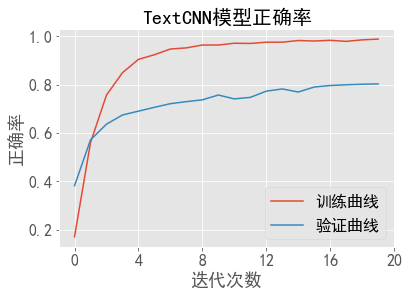

In [23]:
# 绘制训练和验证曲线
plt.plot(history_textcnn.history['acc'])
plt.plot(history_textcnn.history['val_acc'])

plt.legend(['训练曲线', '验证曲线'], loc='lower right', fontsize=16)

plt.title('TextCNN模型正确率', fontsize=20)
plt.xlabel('迭代次数', fontsize=18)
plt.ylabel('正确率', fontsize=18)

plt.xticks(range(0, 21, 4), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [24]:
# 模型测试 评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

7539/7539 [==============================] - 46s    
Test score: 2.34538342175
Test accuracy: 0.788433479123


## 5. TextRNN-LSTM + 可训练Embedding layer

In [37]:
# 模型结构：词嵌入-LSTM-全连接
model = Sequential()
model.add(Embedding(len(word_index) + 1,  embedding_dim, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, trainable=True))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
# 在全连接层上对权重实施L2正则化，对输出实施L1正则化
model.add(Dense(20, activation='softmax', kernel_regularizer=regularizers.l2(0.01), 
                activity_regularizer=regularizers.l1(0.01)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0, verbose=0, mode='auto')]
history_rnn = model.fit(x_train, y_train, batch_size=128, epochs=60, callbacks=tb, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 100)         17921000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 20)                2020      
Total params: 18,003,420
Trainable params: 18,003,420
Non-trainable params: 0
_________________________________________________________________
None
Train on 9045 samples, validate on 2262 samples
Epoch 1/60
9045/9045 [==============================] - 708s - loss: 4.4987 - acc: 0.0826 - val_loss: 4.3217 - val_acc: 0.1706
Epoch 2/60
9045/9045 [==============================] - 712s - loss: 4.2365 - acc: 0.1367 - val_loss: 3.9922 - val_acc: 0.1737
Epoch 3/60
9045/9045 [==============================] - 722s - loss: 4.0244 - acc: 0.16

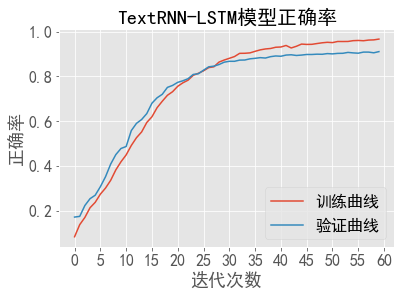

In [38]:
# 绘制训练和验证曲线
plt.plot(history_rnn.history['acc'])
plt.plot(history_rnn.history['val_acc'])

plt.legend(['训练曲线', '验证曲线'], loc='lower right', fontsize=16)

plt.title('TextRNN-LSTM模型正确率', fontsize=20)
plt.xlabel('迭代次数', fontsize=18)
plt.ylabel('正确率', fontsize=18)

plt.xticks(range(0, 61, 5), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [39]:
# 模型测试 评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

7539/7539 [==============================] - 86s    
Test score: 1.90476458956
Test accuracy: 0.885793872032


## 6. RCNN + 可训练Embedding layer

In [40]:
import nltk
import os
import re
from sklearn.datasets import fetch_20newsgroups

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# nltk.download('punkt')

In [41]:
# 读取全集
newsgroups_all = fetch_20newsgroups(subset='all')

# 分词器
tokenizer = Tokenizer(num_words=20000) # 保留词频最高的20000个单词
tokenizer.fit_on_texts(newsgroups_all.data)

word_idx = tokenizer.word_index
len(word_idx)

179209

In [42]:
# 使用word_idx中的映射关系来表示文本 - 训练集和测试集

train_texts = tokenizer.texts_to_sequences( fetch_20newsgroups(subset='train').data )
test_texts = tokenizer.texts_to_sequences( fetch_20newsgroups(subset='test').data )

In [43]:
print(len(train_texts), len(test_texts))
print(train_texts[:2])

11314 7532
[[14, 3133, 1196, 15, 9554, 38, 250, 29, 40, 298, 8, 17, 88, 77, 84, 3133, 1196, 15, 33, 72, 3, 2989, 553, 1725, 32, 225, 7, 26, 1213, 27, 158, 66, 44, 116, 10300, 62, 16, 17, 298, 7, 704, 1, 83, 260, 11, 26, 4, 36, 1257, 2417, 298, 1165, 2, 18, 14, 1, 1347, 17959, 861, 15843, 11, 26, 333, 4, 19270, 1, 4042, 76, 176, 487, 6, 1435, 1, 788, 9276, 26, 1880, 14, 1, 784, 3, 1, 675, 17, 8, 41, 7, 81, 27, 158, 39, 4, 811, 295, 1051, 3252, 207, 3, 2927, 154, 17, 298, 8, 233, 562, 24, 783, 375, 13, 21, 16, 17, 363, 298, 178, 109, 188, 209, 1397, 1380, 2, 13, 35, 57, 7220], [14, 14144, 3245, 126, 461, 15, 753, 7088, 29, 2347, 1333, 6092, 1151, 346, 660, 1151, 346, 12, 2347, 1333, 1310, 426, 2347, 5602, 1333, 1939, 58, 7, 121, 5852, 33, 72, 3, 461, 32, 269, 88, 77, 84, 3245, 126, 461, 15, 4, 1715, 226, 3, 8231, 6440, 64, 6341, 78, 2347, 1333, 7616, 21, 2870, 78, 2960, 12, 17, 6092, 178, 389, 4, 4501, 342, 12425, 57, 2960, 22, 1, 3648, 629, 492, 1210, 5587, 492, 810, 16, 1069, 5, 10391,

In [44]:
print( np.max([np.max(doc) for doc in train_texts]) )
print( np.max([np.max(doc) for doc in test_texts]) )

19999
19999


In [45]:
# 模型结构：词嵌入*3-LSTM*2-拼接-全连接-最大化池化-全连接
# 重新整理数据集
left_train_texts = [[20000] + x[:-1] for x in train_texts] # 保留20000个单词
right_train_texts = [x[1:] + [20000] for x in train_texts] # 保留20000个单词

left_test_texts = [[20000] + x[:-1] for x in test_texts] # 保留20000个单词
right_test_texts = [x[1:] + [20000] for x in test_texts] # 保留20000个单词

In [46]:
MAX_SEQUENCE_LENGTH = 200 # 每篇文档限定200词以内

left_train = pad_sequences(left_train_texts, maxlen=MAX_SEQUENCE_LENGTH)
mid_train = pad_sequences(train_texts, maxlen=MAX_SEQUENCE_LENGTH)
right_train = pad_sequences(right_train_texts, maxlen=MAX_SEQUENCE_LENGTH)

left_test = pad_sequences(left_test_texts, maxlen=MAX_SEQUENCE_LENGTH)
mid_test = pad_sequences(test_texts, maxlen=MAX_SEQUENCE_LENGTH)
right_test = pad_sequences(right_test_texts, maxlen=MAX_SEQUENCE_LENGTH)

In [47]:
print(left_train.shape, mid_train.shape, right_train.shape)
print(left_test.shape, mid_test.shape, right_test.shape)

(11314, 200) (11314, 200) (11314, 200)
(7532, 200) (7532, 200) (7532, 200)


In [48]:
y_train = to_categorical(fetch_20newsgroups(subset='train').target).astype(int)
y_test = to_categorical(fetch_20newsgroups(subset='test').target).astype(int)

In [49]:
# 模型结构：词嵌入*3-LSTM*2-拼接-全连接-最大化池化-全连接
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, concatenate, TimeDistributed, Lambda, Dense
from keras import backend as K

# 模型共有三个输入，分别是左词，中心词和右词
left_context = Input(shape = (None, ), dtype = "int32")
mid_context = Input(shape = (None, ), dtype = "int32")
right_context = Input(shape = (None, ), dtype = "int32")

# 构建词向量
embedding_dim = 100
# embedder = Embedding(20002, embedding_dim, input_length=MAX_SEQUENCE_LENGTH) # 20002=20001+1, MAX_SEQUENCE_LENGTH=200
# 词嵌入, 使用已训练完成的词向量
embedder = Embedding(len(word_idx) + 1, embedding_dim,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True)
left_embed = embedder(left_context)
mid_embed = embedder(left_context)
right_embed = embedder(right_context)

# 左侧的文本向量-正向循环
forward = LSTM(100, return_sequences=True)(left_embed)
# 右侧的文本向量-反向循环
backward = LSTM(100, return_sequences=True, go_backwards = True)(right_embed)
# 拼接3层向量
together = concatenate([forward, mid_embed, backward], axis = 2)

# 潜语意向量 latent semantic vector
semantic = TimeDistributed(Dense(128, activation = "tanh"))(together)

# 自定义池化层
pool_rnn = Lambda(lambda x: K.max(x, axis=1), output_shape=(128, ))(semantic)

#输出层
output = Dense(20, activation="softmax")(pool_rnn)

model = Model(inputs=[left_context, mid_context, right_context], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
input_7 (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
embedding_9 (Embedding)          (None, 200, 100)      17921000    input_5[0][0]                    
                                                                   input_5[0][0]                    
                                                                   input_7[0][0]                    
___________________________________________________________________________________________

In [50]:
history_rcnn = model.fit([left_train, mid_train, right_train], y_train,
                         batch_size=128, epochs=20, validation_split=0.2, shuffle=True)

Train on 9051 samples, validate on 2263 samples
Epoch 1/20
9051/9051 [==============================] - 204s - loss: 2.5860 - acc: 0.2414 - val_loss: 1.9977 - val_acc: 0.4852
Epoch 2/20
9051/9051 [==============================] - 190s - loss: 1.6049 - acc: 0.5783 - val_loss: 1.2518 - val_acc: 0.6695
Epoch 3/20
9051/9051 [==============================] - 189s - loss: 0.9584 - acc: 0.7536 - val_loss: 0.9559 - val_acc: 0.7278
Epoch 4/20
9051/9051 [==============================] - 190s - loss: 0.6808 - acc: 0.8217 - val_loss: 0.7656 - val_acc: 0.7848
Epoch 5/20
9051/9051 [==============================] - 190s - loss: 0.4888 - acc: 0.8752 - val_loss: 0.7004 - val_acc: 0.7941
Epoch 6/20
9051/9051 [==============================] - 190s - loss: 0.3566 - acc: 0.9112 - val_loss: 0.6234 - val_acc: 0.8020
Epoch 7/20
9051/9051 [==============================] - 191s - loss: 0.2625 - acc: 0.9420 - val_loss: 0.5803 - val_acc: 0.8175
Epoch 8/20
9051/9051 [==============================] - 191s - 

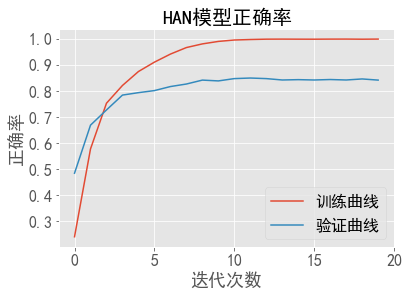

In [51]:
# 绘制模型的训练和验证曲线

plt.plot(history_rcnn.history['acc'])
plt.plot(history_rcnn.history['val_acc'])

plt.legend(['训练曲线', '验证曲线'], loc='lower right', fontsize=16)

plt.title('RCNN模型正确率', fontsize=20) # 名字写错了，应该是RCNN模型正确率
plt.xlabel('迭代次数', fontsize=18)
plt.ylabel('正确率', fontsize=18)

plt.xticks(range(0, 21, 5), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [53]:
# 模型测试 评估
score, acc = model.evaluate([left_test, mid_test, right_test], y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

7532/7532 [==============================] - 30s    
Test score: 0.908347664776
Test accuracy: 0.774561869357


# Embedding_layer不可训练

In [ ]:
# 拆分训练集，验证集和测试集
from sklearn.model_selection import train_test_split

x_tv, x_test, y_tv, y_test = train_test_split(features, labels, test_size=0.4, shuffle=False) # 测试集占据0.4
x_train, x_val, y_train, y_val = train_test_split(x_tv, y_tv, test_size=0.2, shuffle=False) # 验证集占据0.6数据集中的0.2 = 0.12

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

In [17]:
# 词向量加载到embedding层中，trainable=False 使得这个编码层不可再训练
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## 7. CNN + 不可训练的Embedding layer

In [28]:
# 模型记录在logs文件中，使用tensorboard查看
tb = [keras.callbacks.TensorBoard(log_dir='./logs')]

# 输入
main_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float64')
# 词嵌入, 使用已训练完成的词向量
# 词向量加载到embedding层中，trainable=False 使得这个编码层不可再训练
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embed = embedding_layer(main_input)
# 使用3层卷积池化
x = Conv1D(128, 5, activation='relu')(embed)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x) # 可以使用 GlobalMaxPooling1D()(x) 防止计算错误
x = Flatten()(x)
x = Dropout(0.5)(x) # 丢弃50%
x = Dense(128, activation='relu')(x)
preds = Dense(20, activation='softmax')(x)
model = Model(inputs=main_input, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary()) # 查看模型概况

# history_cnn记录训练结果
history_cnn = model.fit(x_train, y_train, batch_size=128, epochs=25, callbacks=tb, validation_data=(x_val, y_val))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1000, 100)         17921000  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 35, 128)           82048     
__________

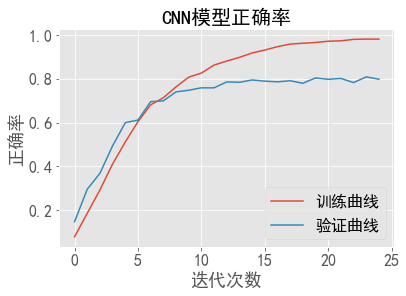

In [29]:
# 绘制模型的训练和验证曲线
# %matplotlib inline
# plt.style.use('ggplot')

# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])

plt.legend(['训练曲线', '验证曲线'], loc='lower right', fontsize=16)

plt.title('CNN模型正确率', fontsize=20)
plt.xlabel('迭代次数', fontsize=18)
plt.ylabel('正确率', fontsize=18)

plt.xticks(range(0, 26, 5), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [30]:
# 模型测试 评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

7539/7539 [==============================] - 25s    
Test score: 1.01512752662
Test accuracy: 0.782729804745


## 8. TextCNN + 不可训练的Embedding layer

In [31]:
from keras import regularizers

# 模型结构：词嵌入-卷积池化*3-拼接-全连接-dropout-全连接

num_filters = 128 # 卷积核的数目

main_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float64')

# 词嵌入, 使用已训练完成的词向量
# 词向量加载到embedding层中，trainable=False 使得这个编码层不可再训练
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embed = embedding_layer(main_input)

# 词窗大小分别为3,4,5
cnn1 = Conv1D(num_filters, 3, padding='same', strides = 1, activation='relu')(embed)
cnn1 = MaxPooling1D(pool_size=4)(cnn1)
cnn2 = Conv1D(num_filters, 4, padding='same', strides = 1, activation='relu')(embed)
cnn2 = MaxPooling1D(pool_size=4)(cnn2)
cnn3 = Conv1D(num_filters, 5, padding='same', strides = 1, activation='relu')(embed)
cnn3 = MaxPooling1D(pool_size=4)(cnn3)

# 合并三个模型的输出向量
cnn = Concatenate(axis=-1)([cnn1,cnn2,cnn3])
flat = Flatten()(cnn)
drop = Dropout(0.5)(flat)
main_output = Dense(20, activation='softmax', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01))(drop)
model = Model(inputs = main_input, outputs = main_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0, verbose=0, mode='auto')]
history_textcnn = model.fit(x_train, y_train, batch_size=128, epochs=20, callbacks=tb, validation_data=(x_val, y_val))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 1000, 100)     17921000    input_4[0][0]                    
____________________________________________________________________________________________________
conv1d_10 (Conv1D)               (None, 1000, 128)     38528       embedding_6[0][0]                
____________________________________________________________________________________________________
conv1d_11 (Conv1D)               (None, 1000, 128)     51328       embedding_6[0][0]                
___________________________________________________________________________________________

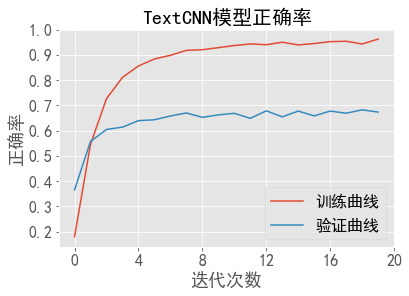

In [32]:
# 绘制训练和验证曲线
plt.plot(history_textcnn.history['acc'])
plt.plot(history_textcnn.history['val_acc'])

plt.legend(['训练曲线', '验证曲线'], loc='lower right', fontsize=16)

plt.title('TextCNN模型正确率', fontsize=20)
plt.xlabel('迭代次数', fontsize=18)
plt.ylabel('正确率', fontsize=18)

plt.xticks(range(0, 21, 4), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [33]:
# 模型测试 评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

7539/7539 [==============================] - 47s    
Test score: 3.21885605664
Test accuracy: 0.664677012922


## 9. TextRNN-LSTM + 不可训练的Embedding layer

In [34]:
# 模型结构：词嵌入-LSTM-全连接
model = Sequential()
model.add(Embedding(len(word_index) + 1,  embedding_dim, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))

# 在全连接层上对权重实施L2正则化，对输出实施L1正则化
model.add(Dense(20, activation='softmax', kernel_regularizer=regularizers.l2(0.01), 
                activity_regularizer=regularizers.l1(0.01)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0, verbose=0, mode='auto')]
history_rnn = model.fit(x_train, y_train, batch_size=128, epochs=60, callbacks=tb, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 100)         17921000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 20)                2020      
Total params: 18,003,420
Trainable params: 82,420
Non-trainable params: 17,921,000
_________________________________________________________________
None
Train on 9045 samples, validate on 2262 samples
Epoch 1/60
9045/9045 [==============================] - 572s - loss: 4.4974 - acc: 0.0785 - val_loss: 4.3313 - val_acc: 0.1247
Epoch 2/60
9045/9045 [==============================] - 582s - loss: 4.2731 - acc: 0.1287 - val_loss: 4.0358 - val_acc: 0.1773
Epoch 3/60
9045/9045 [==============================] - 588s - loss: 4.1173 - acc:

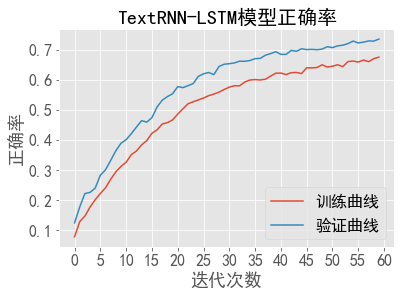

In [35]:
# 绘制训练和验证曲线
plt.plot(history_rnn.history['acc'])
plt.plot(history_rnn.history['val_acc'])

plt.legend(['训练曲线', '验证曲线'], loc='lower right', fontsize=16)

plt.title('TextRNN-LSTM模型正确率', fontsize=20)
plt.xlabel('迭代次数', fontsize=18)
plt.ylabel('正确率', fontsize=18)

plt.xticks(range(0, 61, 5), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [36]:
# 模型测试和评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

7539/7539 [==============================] - 82s    
Test score: 2.35228196596
Test accuracy: 0.729805013817
